## Here is final code where we run the best modified CNN model with different data agumentation techniques as well as combined data augmentation to see if we introduce bias into classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Label array where BH is 0 and Sphalerons are 1
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% into train and 25% into test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

Data augmentation process where we flip horizontally, and rotate images by 180 degrees randomly thus increasing training set.
As well as we siplace images top down on y axes

Commented out part where we crop images in width which can potentially increase models precision

In [8]:
def random_shift_y(img, roll_axis):
    shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1, 1)).item()
    img = torch.roll(img, shift, roll_axis)
    return img

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        img = torch.from_numpy(img)
        
        img_flipped_horizontal = torch.flip(img, dims=[2])
        img_flipped_vertical = random_shift_y(img, roll_axis=1)
        img_rotated_180 = torch.rot90(img, 2, dims=[1, 2])

        augmented_images.extend(
            [img, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return torch.stack(augmented_images)  # Use torch.stack instead of np.array

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=50)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=50)


This code allows us to look on orignial data image as well as its augmented forms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

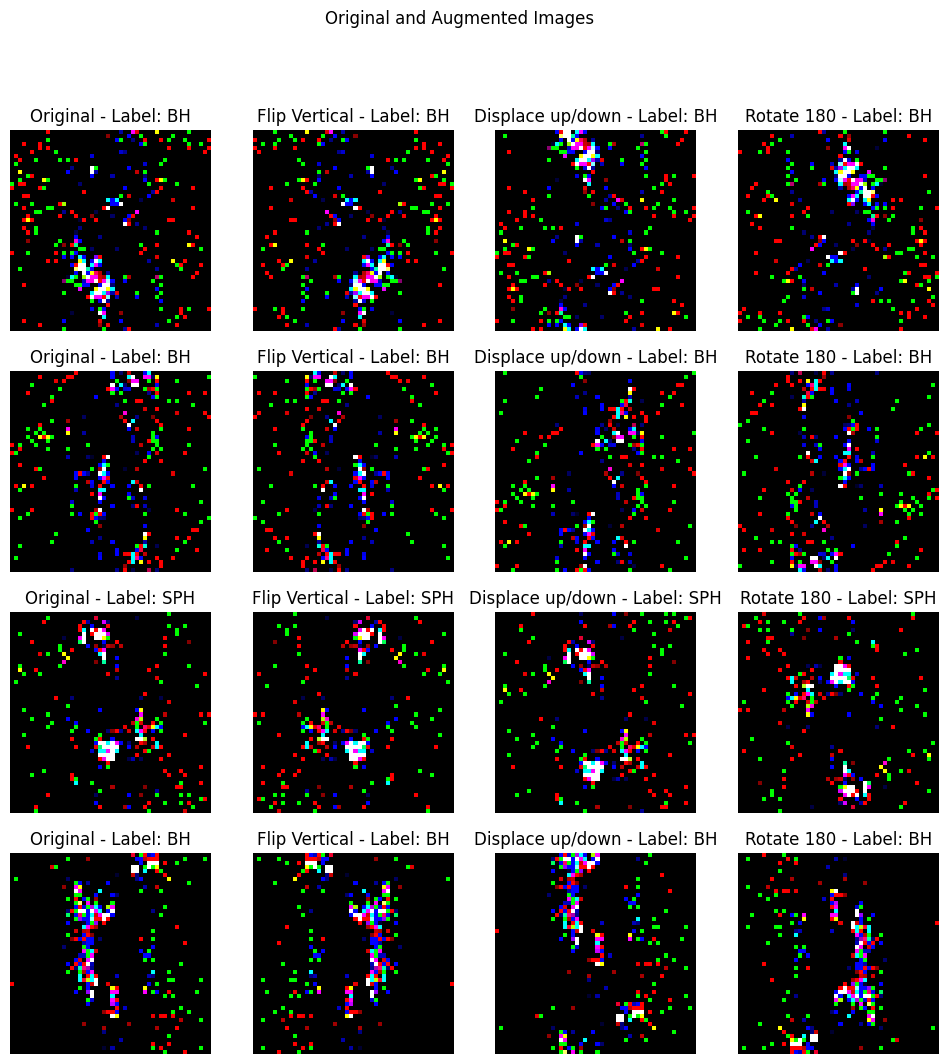

In [9]:
def visualize_comparison(original_images, augmented_images, labels, title, augmentation_info=None):
    n_images = len(original_images)
    n_columns = 4
    n_rows = n_images

    augmented_types = ['Original', 'Flip Vertical', 'Displace up/down', 'Rotate 180']

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 3 * n_rows))
    fig.suptitle(title)

    for i in range(n_images):
        for j in range(n_columns):
            if j == 0:
                img = original_images[i]
            else:
                img = augmented_images[4 * i + j]

            if isinstance(img, np.ndarray):
                img_rgb = np.moveaxis(img, 0, -1) if img.shape[0] == 3 else img
            elif isinstance(img, torch.Tensor):
                img_rgb = np.moveaxis(img.numpy(), 0, -1)

            ax = axs[i, j]
            ax.imshow(img_rgb)
            ax.set_title(f"{augmented_types[j]} - Label: {'BH' if labels[i] == 1 else 'SPH'}") #Change labels such that if 1 Bh if 1 then Sph
            ax.axis('off')

    plt.show()

n_samples = 4
original_images = trainData[:n_samples]
original_labels = trainLabels[:n_samples]
augmented_images = augmented_trainData[:4 * n_samples]

visualize_comparison(original_images, augmented_images, original_labels, title="Original and Augmented Images")


Here we make a call on nnmodel.py in methods fodler where all our models resign

In [10]:
import nnmodel

model = nnmodel.SymmetricNet2(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
 CircularAvgPool2d-7          [-1, 128, 25, 24]               0
 CircularAvgPool2d-8          [-1, 128, 25, 24]               0
 CircularAvgPool2d-9          [-1, 128, 25, 24]               0
          Dropout-10          [-1, 128, 25, 24]               0
           Conv2d-11          [-1, 256, 22, 21]         524,544
      BatchNorm2d-12          [-1, 256, 22, 21]             512
        AvgPool2d-13          [-1, 256, 11, 10]               0
          Dropout-14          [-1, 256,

This function allow us to plot all metrics

In [11]:
import train
import tabulate

Running on the GPU


In [14]:
def display_mean_std_dev(headers, metrics_table_np):
    mean = np.mean(metrics_table_np[:, 1:], axis=0)
    std_dev = np.std(metrics_table_np[:, 1:], axis=0)
    mean_std_row = ['Mean ± Std Dev'] + ['{:.2f} ± {:.2f}'.format(m, s) for m, s in zip(mean, std_dev)]
    print(tabulate([mean_std_row], headers=headers))
    print("\n")

def display_tabular_data(augmentation_types, all_metrics):
    
    for i, _ in enumerate(augmentation_types):

        metrics_table = []
        for epoch_metrics in all_metrics[i]:
            print(epoch_metrics) # Add this line
            metrics_table.append([epoch_metrics['epoch'], epoch_metrics['train_losses'], epoch_metrics['train_accs'], epoch_metrics['test_losses'], epoch_metrics['test_accs'], epoch_metrics['black_holes_accs'], epoch_metrics['sphalerons_accs'], epoch_metrics['precisions'][0], epoch_metrics['precisions'][1], epoch_metrics['recalls'][0], epoch_metrics['recalls'][1]])


        # Print tabular data
        headers = [
            "Epoch", "Train Loss", "Train Acc", "Test Loss", "Test Acc",
            "BH Acc", "Sph Acc", "BH Precision", "Sph Precision", "BH Recall", "Sph Recall"
        ]

        print(tabulate(metrics_table, headers=headers, floatfmt=".2f"))

        metrics_table_np = np.array(metrics_table)
        display_mean_std_dev(headers, metrics_table_np)

        print("\n")
        
def plot_metrics(augmentation_types, all_metrics):
    num_types = len(augmentation_types)
    
    metric_names = list(all_metrics[0].keys())
    num_metrics = len(metric_names)

    plt.figure(figsize=(20, 20))
    
    plot_index = 1
    for metric_name in metric_names:
        plt.subplot(num_metrics//2, 2, plot_index)
        for i, augment_type in enumerate(augmentation_types):
            plt.plot(all_metrics[i][metric_name], label=f'{augment_type} {metric_name}')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} with Different Augmentations')
        plot_index += 1

    plt.tight_layout()
    plt.show()
    
def predict_best_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def plot_confusion_matrix(best_model, augment_type, test_loader, device, best_all_preds, best_all_labels):
    all_preds, all_labels = predict_best_model(best_model, test_loader, device)
    cm = confusion_matrix(best_all_labels, best_all_preds, labels=range(2))

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {augment_type} Augmentation')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1], ['Black Holes', 'Sphalerons'])
    plt.yticks([0, 1], ['Black Holes', 'Sphalerons'])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=16)

    plt.colorbar()
    plt.show()


Here we make a call on train method from methods folder file trainers.py where all training and testing happends as well as plotting of accuracy, loss, precision, recall etc.

Few changes added scheduler and early stopping to prevent from overfitting with changing learning rate if test loss and accuracy doesnt improve. 

Here we train data and get plot of different augmentation techniques


Training with Combined augmentation - Run 1

Training with Combined augmentation - Run 2

Training with None augmentation - Run 1

Training with None augmentation - Run 2

Training with Flip Horizontal augmentation - Run 1

Training with Flip Horizontal augmentation - Run 2

Training with Random Shift Y augmentation - Run 1

Training with Random Shift Y augmentation - Run 2

Training with Rotate 180 augmentation - Run 1

Training with Rotate 180 augmentation - Run 2


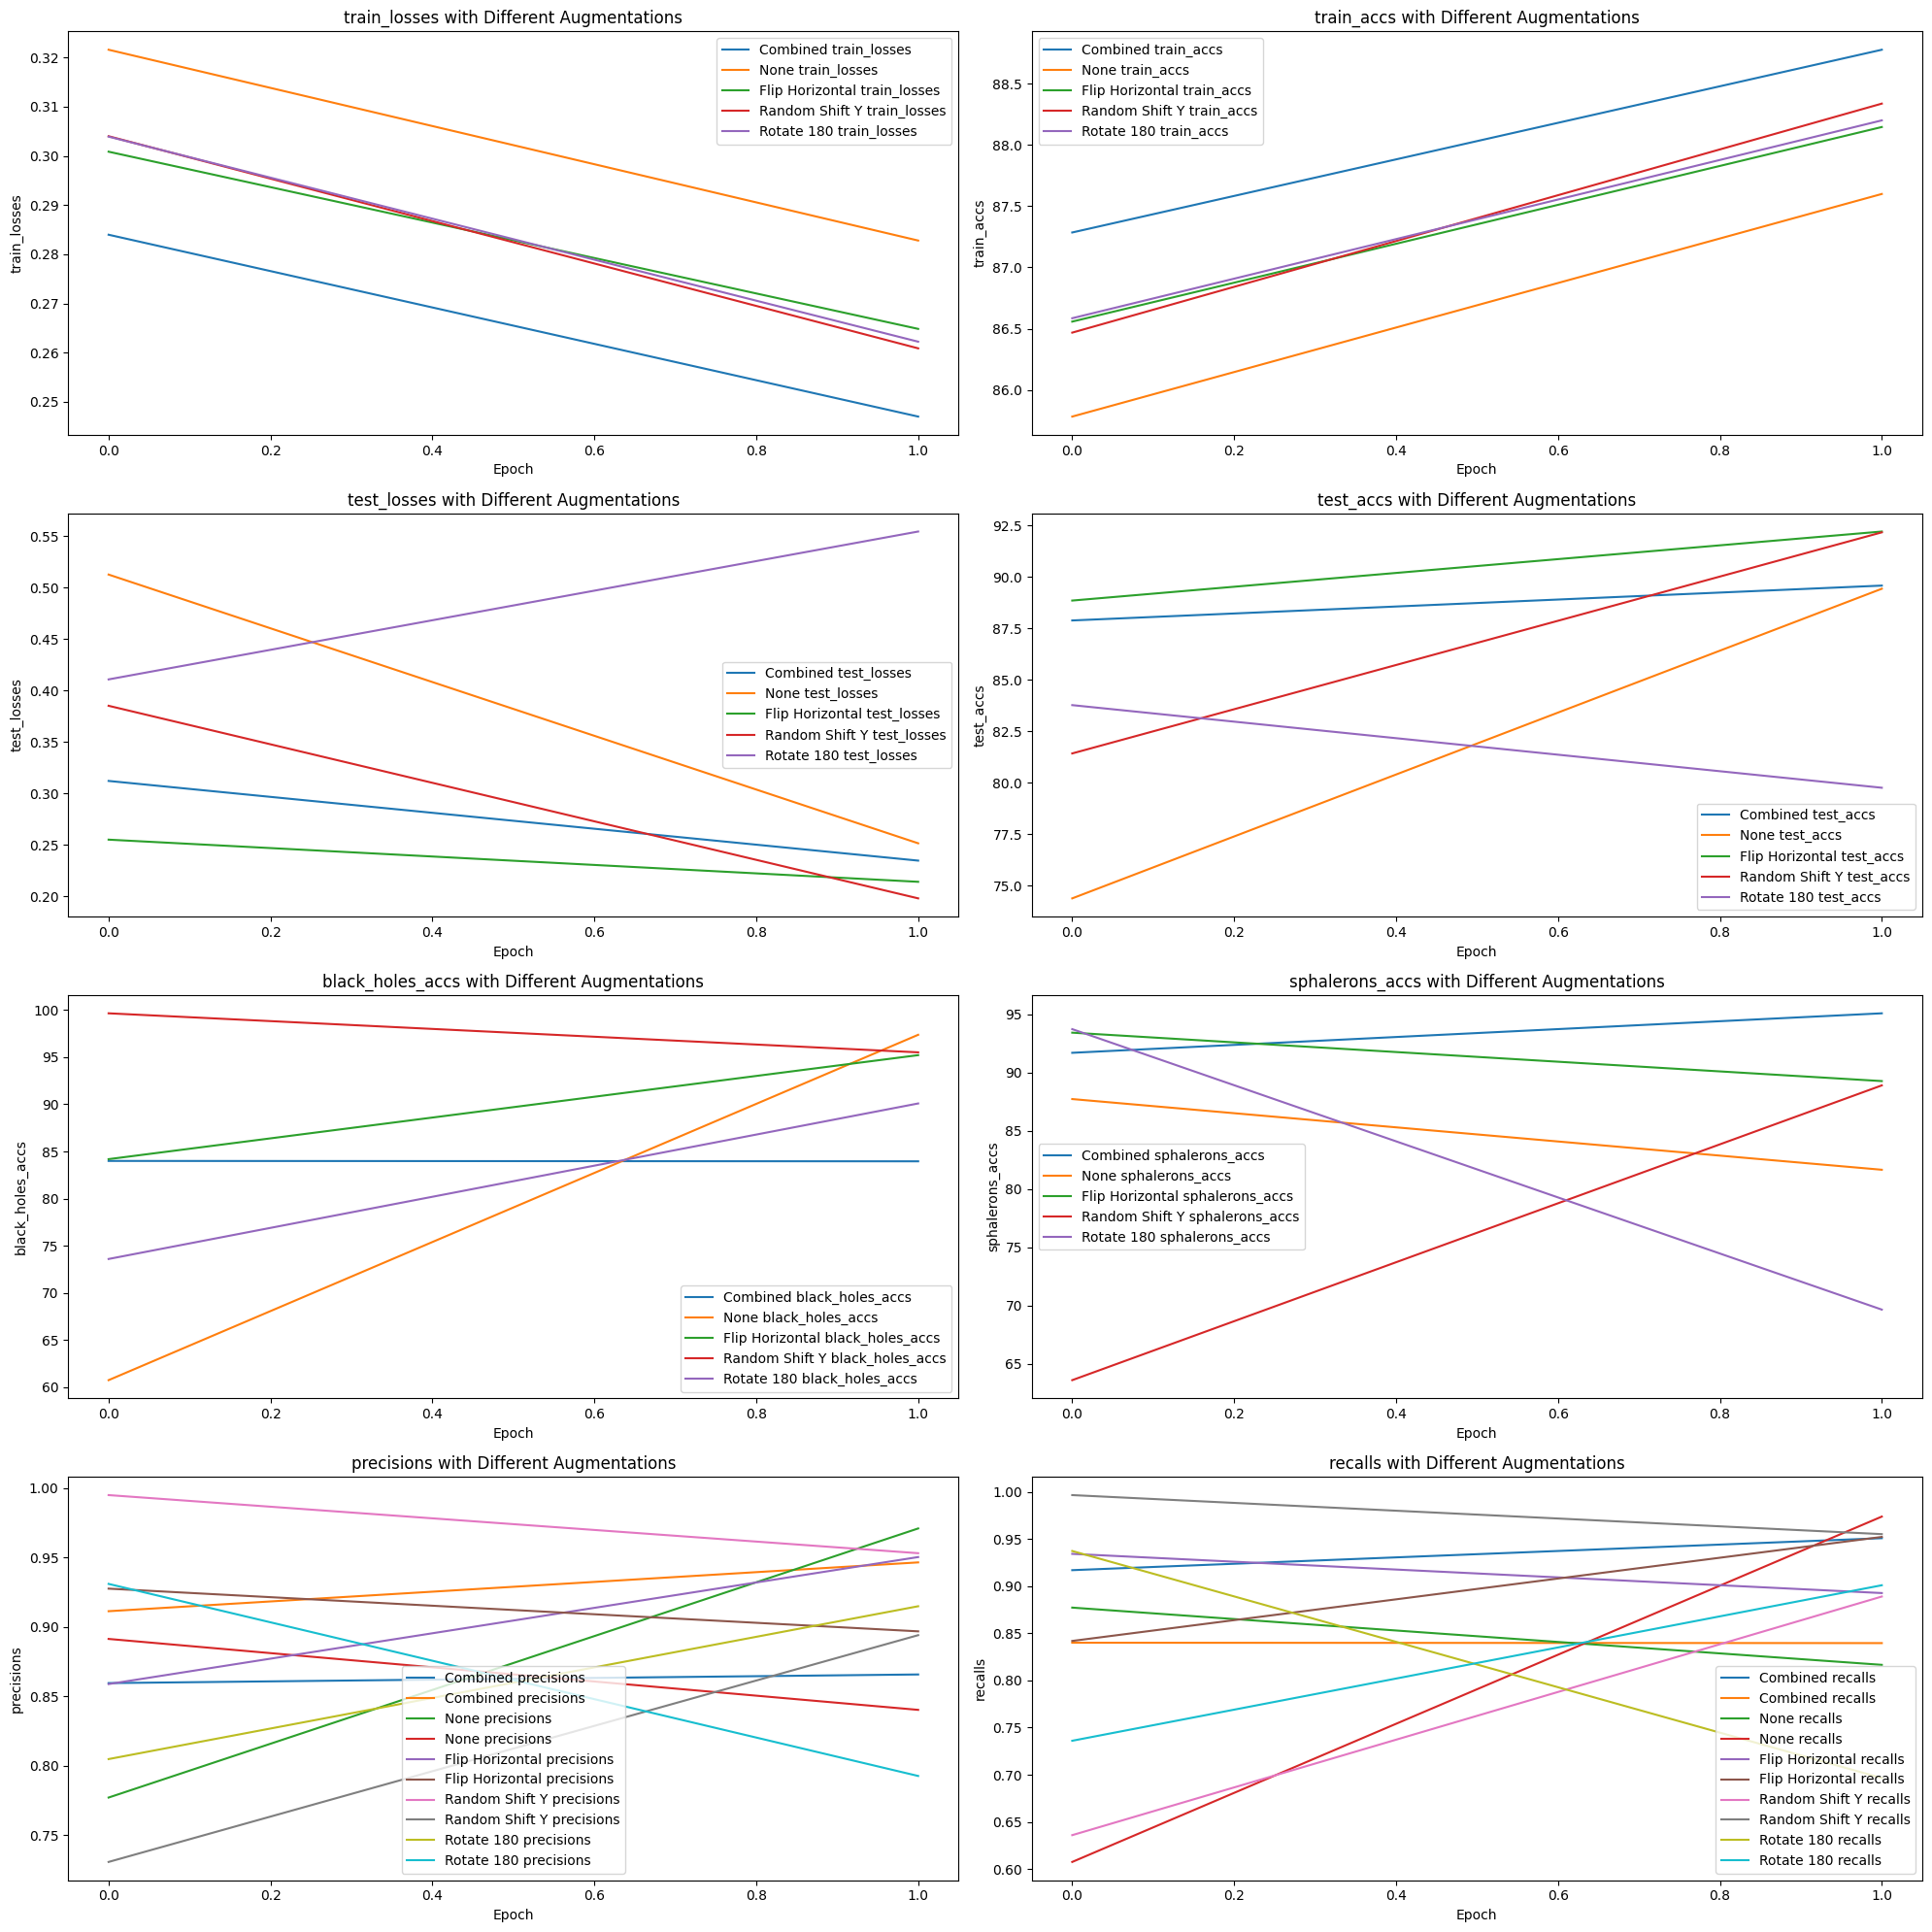

Metrics for Combined augmentation:


TypeError: string indices must be integers

In [15]:
def train_with_augmentations(augmentation_types, num_runs=2):
    all_metrics = []
    all_best_models = []
    all_best_all_preds= []
    all_best_all_labels = []

    augmentation_types = ["Combined"] + augmentation_types

    for augment_type in augmentation_types:
        n_epochs = 2
        avg_metrics = {'train_losses': [0.0] * n_epochs, 'train_accs': [0.0] * n_epochs, 'test_losses': [0.0] * n_epochs, 'test_accs': [0.0] * n_epochs, 'black_holes_accs': [0.0] * n_epochs, 'sphalerons_accs': [0.0] * n_epochs, 'precisions': [0.0] * n_epochs, 'recalls': [0.0] * n_epochs}


        best_models_for_runs = []

        for run in range(num_runs):
            print(f"\nTraining with {augment_type} augmentation - Run {run + 1}")

            if augment_type == "Combined":
                trainLoader_filtered = trainLoader_augmented
            else:
                # Filter the augmented training data based on the augmentation type
                filter_indices = list(range(0, len(augmented_trainData), 4))  # Original images are always included
                if augment_type != "None":
                    aug_type_index = augmentation_types.index(augment_type) - 1
                    filter_indices += list(range(aug_type_index + 1, len(augmented_trainData), 4))
                filtered_trainData = augmented_trainData[filter_indices]  # Added missing line of code
                filtered_trainLabels = trainLabels_repeated[filter_indices]

                # Create a TensorDataset and DataLoader for the filtered training data
                train_filtered = torch.utils.data.TensorDataset(filtered_trainData, filtered_trainLabels)
                trainLoader_filtered = DataLoader(train_filtered, shuffle=True, batch_size=50)

            # Train the model with the filtered training data
            model = nnmodel.ConvModelFPLMod(0.3).to(device)
            optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
            criterion = nn.CrossEntropyLoss().to(device)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)
            
            metrics, best_model, best_all_preds, best_all_labels= train.train(model, trainLoader_filtered, testLoader, optimizer, criterion, n_epochs=n_epochs, scheduler = scheduler)

            # Accumulate the metrics for averaging
            for key in avg_metrics.keys():
                for epoch in range(n_epochs):  # Changed how metrics are added
                    avg_metrics[key][epoch] += metrics[epoch][key]

            best_models_for_runs.append(best_model)

        # Average the metrics
        for key in avg_metrics.keys():
            avg_metrics[key] = [x / num_runs for x in avg_metrics[key]]

        all_metrics.append(avg_metrics)
        all_best_models.append(best_models_for_runs)
        all_best_all_preds.append(best_all_preds)
        all_best_all_labels.append(best_all_labels)

    # Here we plot all metrics
    plot_metrics(augmentation_types, all_metrics)
    
    # This is where we display all tabular data
    display_tabular_data(augmentation_types, all_metrics)

    # Plot confusion matrices for each augmentation type
    for i, augment_type in enumerate(augmentation_types):
        best_models = all_best_models[i]
        best_all_preds = all_best_all_preds[i]  # Get the best_all_preds for the current augmentation type
        best_all_labels = all_best_all_labels[i]  # Get the best_all_labels for the current augmentation type
        for best_model_state in best_models:
            model = nnmodel.ConvModelFPLMod(0.5)
            model.load_state_dict(best_model_state)
            model.to(device)
            plot_confusion_matrix(model, augment_type, testLoader, device, best_all_preds, best_all_labels)  # Pass the best_all_preds and best_all_labels to the function

# Train and compare the model with different data augmentations
augmentation_types = ["None", "Flip Horizontal", "Random Shift Y", "Rotate 180"]
train_with_augmentations(augmentation_types)